## Variational Inference

Let $P(X)$ denote the probability distribution of $X$ an observable random variable and let $Z$ be a random hidden/latent variable.  

We can then write $P(X)$ as $\sum_{Z}P(X|Z)P(Z)$ where $P(Z)$ is some prior belief of a probabilty distribution on the latent variable $Z$.  We also know that based on Bayes rule,  $P(X|Z)$ $=$ $\frac{P(Z|X)P(X)}{P(Z)}$, and in some cases we are interested in the posterior distribution, $P(Z|X)$.  However, $P(Z|X)$ is not available generally and difficult to compute for complex problems.

We can utilize Jensen's inequality where when $f$ is concave $f(E[X]) \leq E[F(X)]$. 

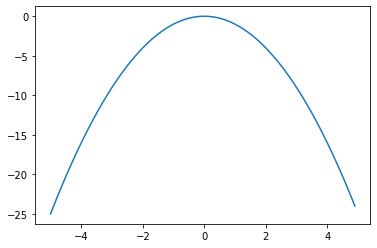

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.1)
y = -x**2
plt.plot(x, y)

So now we have $log P(X) = log \sum_{Z}P(X,Z)$

is equal to $log \sum_{Z}P(X,Z)\frac{Q(Z)}{Q(Z)} = log E_{Q(Z)}[\frac{P(X,Z)}{Q(Z)}) \leq E_{Q(Z)}[log(P(X,Z))] - E_{Q(z)}[Q(Z)]$

we can now do: $E_{Q(Z)}[log(P(X,Z))] - E_{Q(z)}[Q(Z)] = E_{Q}[log(P(X|Z) + log(P(Z))] - E_{Q(z)}[Q(Z)]$  

which is is equal to: $E_{Q(Z)}[log(P(X|Z)] - E_{Q(z)}[log(Q(Z)) - log(P(Z))]$

The term $E_{Q(z)}[log(Q(Z)) - log(P(Z))]$ is a divergence metric (a weaker form of distance) becauses it is not symmetric.  This one in particular is called the KL Divergence, KL(Q(Z)||P(Z)).

The $E_{Q(Z)}[log(P(X|Z)]$ is the log-liklihood term, so maximizing the likelhood of the data under the esimate of the latent variables $Z$ is equal to minimizing the KL Divergence, the difference between our estimate distribution of the latent variables and the real prior distribution.  Once we optimize Q(Z) we can use it approximate the posterior Q(Z|X))

## Normalizing Flows

Normalizing flows transform some simple distribution P(Z) to a more complicated distribution P(X), so the advantage of normalizing flows is that we are only optimizing log-liklihood of the data and not any other parameters.  One con is that Z must be the same size as X, however, this is useful for our project!

The idea is that if we have a data distribution $X$ and some invertible transformation, f, then there is a random variable $Z$ which $f$ maps X to.  $P(X = x) = P(f(X) = f(x)) = P(Z=z)$

We know that $\int_{B} p_{X} dx = \int_{B^{`}} p_{Z} dz$, where $P(X\in B) and P(Z \in B^{`})$

If we take small region of X and Z: $dx \cdot
 p_X(x) = dz \cdot
 p_Z(z)$

$p_X(x) = \frac{dz}{dx} \cdot p_Z(z)$

Since $z = f(x)$, $p_X(x) = \frac{df(x)}{dx} \cdot p_Z(f(x))$

Which we can reexpress with the determinant for larger dimensions of our distributions:
$p_X(x) = det\begin{bmatrix} \frac{df(x)}{dx} \end{bmatrix} \cdot p_Z(f(x))$

Take the log of both sides:
    
$log(p_X(x)) = log(det\begin{bmatrix} \frac{df(x)}{dx} \end{bmatrix}) \cdot log(p_Z(f(x)))$

The determinant is the amount of change the transformation function $f$ applies to the probability distribution $p_X$

Finally, $log(p_Z(f(x)))$ constrains $f$ to transform x to the distribution $p_{Z}$

Therefore we are only optimizing the log-liklihood of the data with respect so much transformation distribution.

## The Forward Pass

$f(x) = z$ which is a combination of copying values while stretching and shifting others.  A type of flow is Real-NVP, where we split the data into two and transform each set one at a time:

$z^{1}_{1:k} = x_{1:k}$ <br>
$z_{k+1:d} = x_{k+1:d} \otimes exp(\sigma(x_{1:k}+\mu(x_{1:k})$

where $\sigma$ and $\mu$ are some arbritatry functions which are usually neural networks. 



## Universal Approximation Theorem

We can do this because Neural networks are universal (i.e. they can approximate any continuous function) from using different activation functions (sigmod, logistic) and arrangements of such functions.  

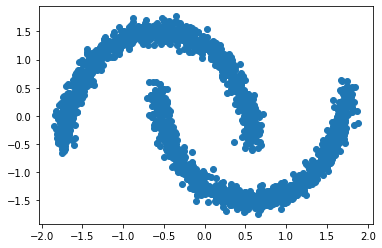

In [3]:
from __future__ import division

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# normalize
X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])

In [4]:
import torch
import torch.nn as nn 
from math import pi 

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

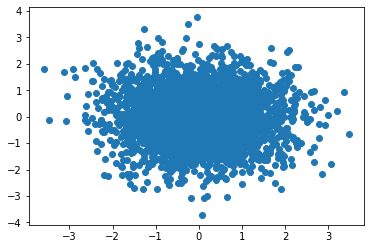

In [5]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,))
plt.scatter(Z[:, 0], Z[:, 1])
plt.show()

In [6]:
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False): # x to z
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)  # calculate the determinant (jacobian)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False): # z to x
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [7]:
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for _ in range(epochs):

        # get batch 
        X, _ = datasets.make_moons(n_samples=batch_size, noise=.05)
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
    return losses

def view(model, losses):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    n_samples = 3000
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()

In [8]:
## Model Params
d = 2 # Dataset size
k = 1 # Number of slows

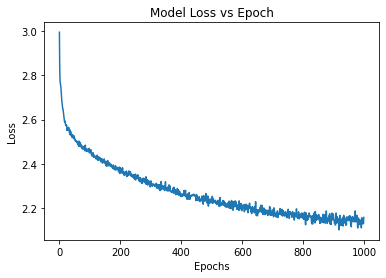

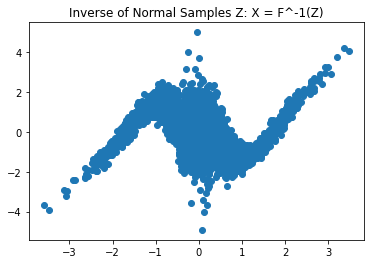

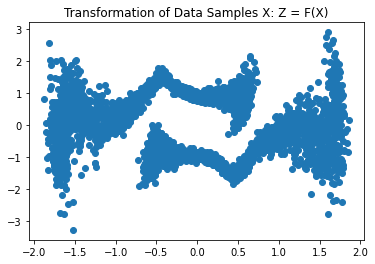

In [9]:
model = R_NVP(d, k, hidden=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

## Multiple Flows

In [10]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

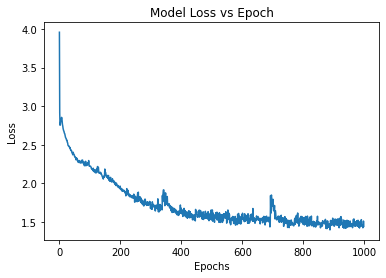

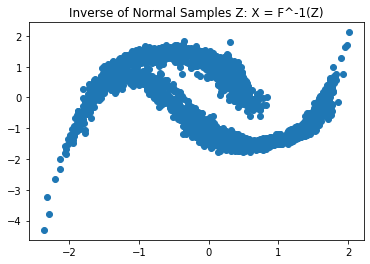

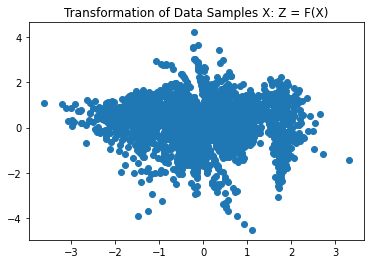

In [11]:
model = stacked_NVP(d, k, hidden=512, n=3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

Idea is to use learn the distribution of 
- strength of selection ($w^2$)
- selection coefficient ($\gamma = 4NS$)
- true effect size ($\beta$)

What we have:
- $X$ vector of frequency of alleles
- $\tilde{\beta}$ vector of estimated effect size
- $D$ LD Score matrix
- $\sigma$ vector of standard errors

Likelihood of $\tilde{\beta} \sim Normal(F\beta,F)$ where $F = \sigma \cdot D \cdot \sigma$





The true $\beta \sim Normal(0, \frac{w^{2}}{N}*\gamma)$ <br>
So $g(\tilde{\beta})=\beta$

$X \sim f(\gamma)$

## Use normalizing flows to learn the distrubtion of fitness effects

For example $f(\tilde{\beta}) = \beta$ 

and then  $f(\beta) = w^2, \gamma$ 

and finally, $X = f^(-1)(\gamma)$

<img src="generative.png"> 

Where $\theta$ are the parameters to generate the data, and $z_{3}$ is $\beta$


<img src="infernce.png"> 

$\phi$ is the parameters to infer the latent parameters. (X here is $\tilde{\beta}$